<h1 align=center><font size = 5>Find best location to open new restaurant in Toronto?</font></h1>

## Introduction

In this project I explore by coding to find where is the location for opening new restaurant in Toronto?

First of all, let's download all the dependencies that we will need.

In [5]:
!conda install -c conda-forge geopy  # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium=0.5.0  # uncomment this line if you haven't completed the Foursquare API lab

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [7]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
import seaborn as sns
print('Libraries imported.')

Libraries imported.


## 1.Data acquisition and cleaning 

### 1.1.Collect postcode, latitude,longtitude for  locations in Toronto from Wikipedia

In [8]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)

# skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)
# give "Not assigned" Neighborhoods same name as Borough:
df.Neighbourhood.replace("Not assigned", df.Borough, inplace=True)

# copy Borough value to Neighborhood if NaN:
df.Neighbourhood.fillna(df.Borough, inplace=True)
# drop duplicate rows:
df=df.drop_duplicates()

# extract titles from columns
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

# delete Toronto annotation from Neighbourhood:
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))

# combine multiple neighborhoods with the same post code
df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(df['Neighbourhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.head(20)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park (Toronto),Queen's Park
6,M1B,"Scarborough, Toronto","Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [9]:
#download Geo-spatial data
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfll.set_index("Postcode")
df2.set_index("Postcode")
#merge two into single dataframe
toronto_data=pd.merge(df2, dfll)
toronto_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


### 1.2. Download the population data for locations in Toronto from https://en.m.wikipedia.org/wiki/Demographics_of_Toronto

In [10]:
import csv
r = requests.get('https://en.m.wikipedia.org/wiki/Demographics_of_Toronto')
soup = BeautifulSoup(r.text, 'html.parser')
table = soup.find_all('table',{'class':'wikitable sortable'})[1]
headers = [header.text for header in table.find_all('th')]

table_rows = table.find_all('tr')        
rows = []
for row in table_rows:
   td = row.find_all('td')
   row = [row.text for row in td]
   rows.append(row)

with open('TORONTO_POPULATION.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerow(headers)
   writer.writerows(row for row in rows if row)
print("Loaded data completely...")


Loaded data completely...


Load data from saved file of csv to data frame

In [11]:
pop_data=pd.read_csv('TORONTO_POPULATION.csv')
pop_data.head()

,Top 20 Ethnic origins in the City of Toronto,Population (2016)[33],Percentage,Riding with Highest Concentration,Percentage .1
0,Chinese,"332,830",12.5,Scarborough-Agincourt\n,47.0\n
1,English,"331,890",12.3,Beaches-East York\n,24.2\n
2,Canadian,"323,175",12.0,Beaches-East York\n,19.7\n
3,Irish,"262,965",9.8,Parkdale-High Park\n,20.0\n
4,Scottish,"256,250",9.5,Beaches-East York\n,18.9\n


Rename columns to standard names to be easy for coding

In [12]:
pop_data.columns = pop_data.columns.str.replace('\n','')
pop_data.rename(columns = {'Top 20 Ethnic origins in the City of Toronto' : 'Ethnic','Percentage':'Percentage',
                   'Population (2016)[33]':'Population',
                   'Riding with Highest Concentration':'Borough', 
                   'Percentage.1':'Borough_percent'}, inplace=True)
pop_data.head()

,Ethnic,Population,Percentage,Borough,Borough_percent
0,Chinese,"332,830",12.5,Scarborough-Agincourt\n,47.0\n
1,English,"331,890",12.3,Beaches-East York\n,24.2\n
2,Canadian,"323,175",12.0,Beaches-East York\n,19.7\n
3,Irish,"262,965",9.8,Parkdale-High Park\n,20.0\n
4,Scottish,"256,250",9.5,Beaches-East York\n,18.9\n


Make cleaning and standard data

In [13]:
pop_data.columns = pop_data.columns.str.replace(' ', '')
pop_data.columns = pop_data.columns.str.replace('\'','')

# standrard
pop_data['Ethnic']=pop_data['Ethnic'].replace(to_replace='\n', value='', regex=True)
pop_data['Population']=pop_data['Population'].replace(to_replace='\n', value='', regex=True)
pop_data['Percentage']=pop_data['Percentage'].replace(to_replace='\n', value='', regex=True)
pop_data['Borough']=pop_data['Borough'].replace(to_replace='\n', value='', regex=True)
pop_data['Borough_percent']=pop_data['Borough_percent'].replace(to_replace='\n', value='', regex=True)
pop_data['Population']=pop_data['Population'].replace(to_replace=',', value='', regex=True)
pop_data.head(20)

,Ethnic,Population,Percentage,Borough,Borough_percent
0,Chinese,332830,12.5,Scarborough-Agincourt,47.0
1,English,331890,12.3,Beaches-East York,24.2
2,Canadian,323175,12.0,Beaches-East York,19.7
3,Irish,262965,9.8,Parkdale-High Park,20.0
4,Scottish,256250,9.5,Beaches-East York,18.9
5,East Indian,202675,7.5,Etobicoke North,22.2
6,Italian,182495,6.8,Etobicoke Centre,15.1
7,Filipino,162605,6.0,York Centre,17.0
8,German,130900,4.9,Parkdale-High Park,9.8
9,French,122615,4.6,Parkdale-High Park,8.9


In [14]:
#convert type of Population for coding easily
pop_data['Population']=pop_data['Population'].astype(np.float64)

To clean some data that is not necessary for the problems

In [15]:
# create a copy to avoid reference
pop_data_clean=pop_data.copy() 
pop_data_clean.drop(['Ethnic','Percentage','Borough_percent'],axis=1,inplace=True) #drop columns that are not essential
pop_data_clean=pop_data_clean[pop_data_clean['Borough']!=''] #drop rows that there is no data of population
pop_data_clean_ok=pop_data_clean.groupby('Borough').sum().reset_index() 

# split name into borough and neibourhood and standard
pop_data_clean_ok[['Borough1','Borough2']] = pop_data_clean_ok.Borough.str.split("-",expand=True) 
pop_data_clean_ok['Borough2'] = np.where(pop_data_clean_ok['Borough2'].isnull(),pop_data_clean_ok['Borough1'],pop_data_clean_ok['Borough2'])
# assign lat,lng is np.nan to process later
pop_data_clean_ok['Lat']=np.nan
pop_data_clean_ok['Lng']=np.nan
# show data to see visually
pop_data_clean_ok.head(20)

,Borough,Population,Borough1,Borough2,Lat,Lng
0,Beaches-East York,911315.0,Beaches,East York,NaN,NaN
1,Davenport,100420.0,Davenport,Davenport,NaN,NaN
2,Eglinton-Lawrence,114530.0,Eglinton,Lawrence,NaN,NaN
3,Etobicoke Centre,254835.0,Etobicoke Centre,Etobicoke Centre,NaN,NaN
4,Etobicoke North,202675.0,Etobicoke North,Etobicoke North,NaN,NaN
5,Humber River-Black Creek,90065.0,Humber River,Black Creek,NaN,NaN
6,Parkdale-High Park,516480.0,Parkdale,High Park,NaN,NaN
7,Scarborough-Agincourt,332830.0,Scarborough,Agincourt,NaN,NaN
8,Scarborough-Rouge Park,58180.0,Scarborough,Rouge Park,NaN,NaN
9,Toronto-Danforth,57425.0,Toronto,Danforth,NaN,NaN


Start steps to conbine all of downloaded above datasets to create good datasets consists: lat,lng,population for data analysis

In [24]:
#function to combine lat,lng between datasets
#create function to filter to fill by keyword is location keywords
def getLatLngOffline(x):
    address1=x[2]
    address2=x[3]
    #print('Get lat,lng of address ',address)
    #print('Compare in ',lst_borough)
    #print('Is need to compare ',np.isnan(x[0]))
    if np.isnan(x[0]):
        #for str1 in lst_borough:
        df=toronto_data.loc[toronto_data['Neighborhood'].str.contains(address1) & toronto_data['Neighborhood'].str.contains(address2)]
        if( df.shape[0]>0):
            df.reset_index(inplace=True)
            print('Found lat,lng:',address1)
            return pd.Series([df.loc[0,'Latitude'],df.loc[0,'Longitude']])
        '''else:
            df=toronto_data.loc[toronto_data['Neighborhood'].str.contains(address1)]
            if( df.shape[0]>0):
                df.reset_index(inplace=True)
                print('Found lat,lng:',address1)
                return pd.Series([df.loc[0,'Latitude'],df.loc[0,'Longitude']])
        '''
    return pd.Series([x[0],x[1]])

Call code to combine lat,lng

In [25]:
#iterate to set lat,lng for each rows in data-frame
pop_data_clean_ok[['Lat','Lng']] = pop_data_clean_ok[['Lat','Lng','Borough1','Borough2']].apply(lambda x: getLatLngOffline(x), axis=1)
pop_data_clean_ok.head()

,Borough,Population,Borough1,Borough2,Lat,Lng
0,Beaches-East York,911315.0,Beaches,East York,43.676357,-79.293031
1,Davenport,100420.0,Davenport,Davenport,NaN,NaN
2,Eglinton-Lawrence,114530.0,Eglinton,Lawrence,NaN,NaN
3,Etobicoke Centre,254835.0,Etobicoke Centre,Etobicoke Centre,NaN,NaN
4,Etobicoke North,202675.0,Etobicoke North,Etobicoke North,NaN,NaN


As we saw, because data that we downloaded aboved not completely full of lat,lng so we need make some api online to fill in lat,lng to missing values:

In [26]:
#create function to get online for columns lat, lng in data frame is no available
def getLatLngOnline(x):
    if np.isnan(x[1]):
        address=x[0]
        #address = 'Scarborough-Agincourt,Toronto, ON, Canada'
        geolocator = Nominatim(user_agent="to_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {}, Canada are {}, {}.'.format(address,latitude, longitude))
        return pd.Series([location.latitude,location.longitude])
    return pd.Series([x[1],x[2]]) 

Call function to get lat,lng to fill-in lat,lng for each row of data-frame

In [27]:
pop_data_clean_ok[['Lat','Lng']] = pop_data_clean_ok[['Borough','Lat','Lng']].apply(lambda x: getLatLngOnline(x), axis=1)
pop_data_clean_ok.head()

The geograpical coordinate of Davenport, Canada are 41.5236436, -90.5776368.
The geograpical coordinate of Eglinton-Lawrence, Canada are 43.7192647, -79.429765.
The geograpical coordinate of Etobicoke Centre, Canada are 43.6798327, -79.5389927.
The geograpical coordinate of Etobicoke North, Canada are 43.7410925, -79.5892249.
The geograpical coordinate of Humber River-Black Creek, Canada are 43.7337368, -79.5382285.
The geograpical coordinate of York Centre, Canada are 43.750241, -79.463352.


,Borough,Population,Borough1,Borough2,Lat,Lng
0,Beaches-East York,911315.0,Beaches,East York,43.676357,-79.293031
1,Davenport,100420.0,Davenport,Davenport,41.523644,-90.577637
2,Eglinton-Lawrence,114530.0,Eglinton,Lawrence,43.719265,-79.429765
3,Etobicoke Centre,254835.0,Etobicoke Centre,Etobicoke Centre,43.679833,-79.538993
4,Etobicoke North,202675.0,Etobicoke North,Etobicoke North,43.741093,-79.589225


Prepare some data for data analysis

In [29]:
#Create copy data to avoid reference
pop_data_ready=pop_data_clean_ok.copy()
#### Prepare data for maps of center visualization 
address = pop_data_ready.loc[0,'Borough']
latitude = pop_data_ready.loc[0,'Lat']
longitude = pop_data_ready.loc[0,'Lng']
print('The geograpical coordinate of {}, Canada are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Beaches-East York, Canada are 43.67635739999999, -79.2930312.


#### 1.3. we are going to explore all of current restauntants in these locations in the Toronto by using Foursquare API

Define Foursquare Credentials and Version

In [38]:
CLIENT_ID = 'JBREGZ4UNA53HX43WMAD4TQ2X2XJWMX5DPHEZEIZHQA0ACNP' # your Foursquare ID
CLIENT_SECRET = 'VNS40KF3V4MGSWWAV0IGQINZIGIT1EQKNCWBFPOS3QF1JMOJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
categoryid='4d4b7105d754a06374d81259' # category is food restaurants according to description of url:https://developer.foursquare.com/docs/resources/categories
LIMIT=200

Now, let's get the explore current number of food restaurants within a radius of near borough in Toroton in meters.

In [39]:
# define function that extracts the category of the venue from return calling of FourSquare API
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to call and get list of restaurant for each locations.

In [40]:
def getNearbyRestaurants(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryid={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(categoryid,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        #print('call to ',url)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if len(v['categories'])>0 ])

    nearby_restaurant = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    return(nearby_restaurant)

Now write the code to run the above function on each locations 

In [41]:
#call to API Squares to get information of restaurants in each location
print('Loading data....')
toronto_restaurants = getNearbyRestaurants(names=pop_data_ready['Borough'],
                                   latitudes=pop_data_ready['Lat'],
                                   longitudes=pop_data_ready['Lng'])
print('Loaded data completely....')


Loading data....
Loaded data completely....


Let's check and see the size of the result of above dataframe 

In [42]:
print(toronto_restaurants.shape)
toronto_restaurants.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Restaurant', 
                  'Restaurant_Latitude', 
                  'Restaurant_Longitude', 
                  'Restaurant_Category']    
toronto_restaurants.head()

(1217, 7)


,Neighborhood,Latitude,Longitude,Restaurant,Restaurant_Latitude,Restaurant_Longitude,Restaurant_Category
0,Beaches-East York,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
1,Beaches-East York,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
2,Beaches-East York,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
3,Beaches-East York,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
4,Beaches-East York,43.676357,-79.293031,Beaches BJJ,43.672703,-79.289013,Martial Arts Dojo


Let's check how many category of restaurant were returned for each location

In [44]:
category_restaurant=toronto_restaurants['Restaurant_Category'].unique()
category_restaurant

array(['Other Great Outdoors', 'Trail', 'Park', 'Pub',
       'Martial Arts Dojo', 'Bakery', 'Coffee Shop',
       'Vegetarian / Vegan Restaurant', 'Gym / Fitness Center', 'Lounge',
       'Playground', 'Spa', 'Residential Building (Apartment / Condo)',
       'Speakeasy', 'Housing Development', 'Flower Shop', 'Nail Salon',
       'Student Center', 'Music Venue', 'Tech Startup', 'Bridge',
       'Furniture / Home Store', 'Miscellaneous Shop', 'Baby Store',
       'Mobile Phone Shop', 'School', "Women's Store", 'Laundry Service',
       'Building', 'Jewelry Store', 'Government Building', 'Bus Stop',
       'Salon / Barbershop', 'Office', 'Wine Shop', 'Dance Studio',
       'General College & University', 'Convenience Store',
       "Doctor's Office", 'Art Gallery', 'Gastropub', 'Nursery School',
       'Middle School', 'Asian Restaurant', 'Lawyer', 'Grocery Store',
       'Church', 'BBQ Joint', 'Food Truck', 'Tea Room', 'Burger Joint',
       'Bus Station', 'Moving Target', 'Bike Shop',

##### Data from API return a lot of categoríe which  company XYZ don't care because if quite large: including food and non-food restaurant,<br>
Company XYZ JSC just caring for the kind of food restaurant so I will remove some information category that is not fit with the demand of Company XYZ JSC

In [45]:
#define keywords filter
def is_need_keep(list_str,item):
    for str in list_str:
        if str in item:
            return True
    return False

In [46]:
#define some keywords to filter off from result from FourSquare API Calling
list_keyword_need_to_remove=['Repair','Service','School','Pet','Gym','Golf','Warehouse','Office','Nail','Pet','Pharmacy']
category_restaurant_care=[item for item in category_restaurant if (is_need_keep(['Restaurant','Food','Coffee','Dessert','Café','Bakery','Bar','Cafeteria'],item)) ]
len(category_restaurant_care)

46

In [48]:
#print all of unique category that company XYZ is caring for
category_restaurant=toronto_restaurants['Restaurant_Category'].unique()
len(category_restaurant_care)

46

Let's find out how many correct restaurant can be collected in final data set

In [50]:
toronto_restaurants_care=toronto_restaurants.copy()
toronto_restaurants_care['Restaurant_Category_Remove'] =toronto_restaurants_care['Restaurant_Category'].apply(lambda x: 'True' if x in category_restaurant_care else 'False')
toronto_restaurants_care=toronto_restaurants_care[toronto_restaurants_care['Restaurant_Category_Remove']=='True']
toronto_restaurants_care.head()

,Neighborhood,Latitude,Longitude,Restaurant,Restaurant_Latitude,Restaurant_Longitude,Restaurant_Category,Restaurant_Category_Remove
5,Beaches-East York,43.676357,-79.293031,Naturalis,43.672194,-79.289732,Bakery,True
6,Beaches-East York,43.676357,-79.293031,Tim Hortons,43.678705,-79.298148,Coffee Shop,True
7,Beaches-East York,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant,True
38,Beaches-East York,43.676357,-79.293031,Deb's Rainbow of Hair Design,43.680424,-79.290726,Salon / Barbershop,True
59,Beaches-East York,43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant,True


In [51]:
print('There are {} uniques restaurant devide into {} categories in {} locations '.format(len(toronto_restaurants_care['Restaurant'].unique()),len(toronto_restaurants_care['Restaurant_Category'].unique()),len(toronto_restaurants_care['Neighborhood'].unique())))

There are 157 uniques restaurant devide into 46 categories in 12 locations 


### 2.Data Analysis

### 2.1. Prepare data for visualization data

Let us see how densitively current distribution of restaurant and pupolation in locations in Toronto?

2.1.1.Firstly, we are going to count number of restaurant for each location to visualize it on plot

In [59]:
#count number of restaurant for each location
df_graph_res=toronto_restaurants_care[['Neighborhood','Restaurant']]
df_graph_res_count=df_graph_res.groupby('Neighborhood').count().reset_index()
df_graph_res_count.head()

,Neighborhood,Restaurant
0,Beaches-East York,12
1,Davenport,4
2,Eglinton-Lawrence,14
3,Etobicoke Centre,10
4,Etobicoke North,32


2.1.2.Secondly, we are going to combine dataset consists of features:  number of population,count of restaurant for each location

In [60]:
#combine dataset consists of features:  number of population,count of restaurant for each location
pop_data_ready['Neighborhood']=pop_data_ready['Borough']
df_last=pd.merge(right=pop_data_ready,left=df_graph_res_count,left_on='Neighborhood',right_on='Neighborhood')
#drop some columns that is not essential
df_last.drop(['Borough','Borough1','Borough2'],axis=1,inplace=True)
df_last.head()

,Neighborhood,Restaurant,Population,Lat,Lng
0,Beaches-East York,12,911315.0,43.676357,-79.293031
1,Davenport,4,100420.0,41.523644,-90.577637
2,Eglinton-Lawrence,14,114530.0,43.719265,-79.429765
3,Etobicoke Centre,10,254835.0,43.679833,-79.538993
4,Etobicoke North,32,202675.0,43.741093,-79.589225


### 2.2. Starting visualization data
#### 2.2.1.See in graph bar about number of Restaurants and populations

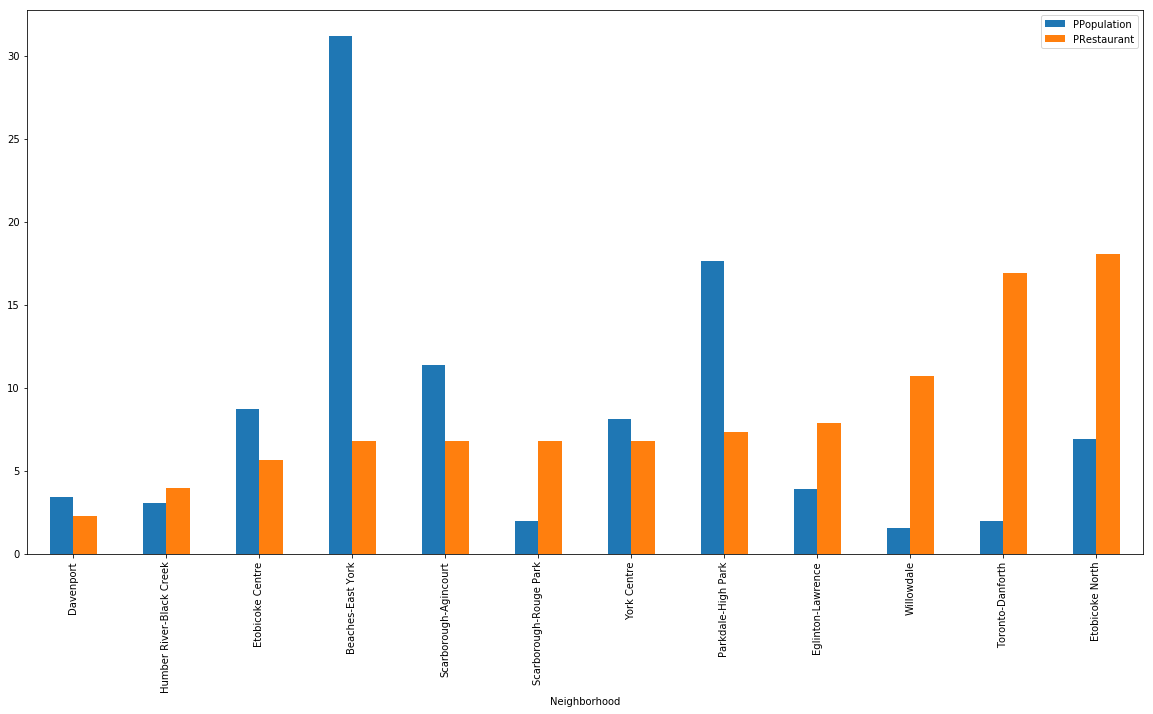

In [62]:
df_last_data=df_last.copy()
df_last_data['PPopulation'] = 100*df_last_data['Population']/df_last_data['Population'].sum()
df_last_data['PRestaurant'] = 100*df_last_data['Restaurant']/df_last_data['Restaurant'].sum()
df_last_data.sort_values(['PRestaurant'],ascending=True,inplace=True)

df_last_data.drop(['Lat','Lng','Population','Restaurant'],axis=1,inplace=True)
df_last_data.reset_index()
df_last_data.set_index('Neighborhood',inplace=True)
#df_last_data.head()
df_last_data.plot(kind='bar',stacked=False,figsize=(20, 10))


We could see the top 3 location is the most potential location for open new restaurant in Toronto is:

#### 2.2.2. See some correlation betwen % of restaurant and % pupolations for each location

(0, 19.136721419272114)

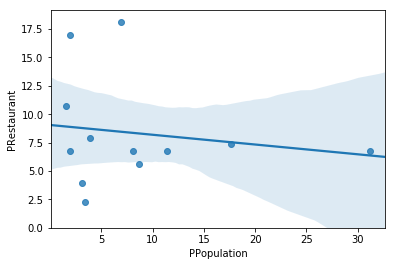

In [69]:
import matplotlib.pyplot as plt
sns.regplot(x='PPopulation',y='PRestaurant',data=df_last_data)
plt.ylim(0,)

#### 2.2.3. See some correlation betwen number of restaurant and total of pupolations for each location

(0, 33.916501237282404)

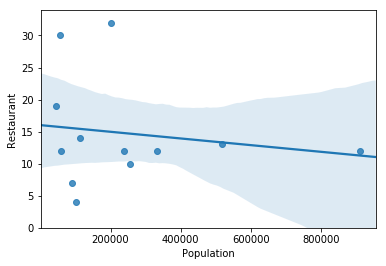

In [70]:
sns.regplot(x='Population',y='Restaurant',data=df_last)
plt.ylim(0,)

#### 2.2.3. Visualization on maps

In [72]:
# create map of Toronto using latitude and longitude values
map_restaurant = folium.Map(location=[latitude, longitude], zoom_start=12)
data_test=toronto_restaurants_care.copy()
# add markers to map
for lat, lng, neighborhood, restaurant in zip(data_test['Restaurant_Latitude'], data_test['Restaurant_Longitude'], data_test['Neighborhood'], data_test['Restaurant']):
    label = '{}, {}'.format(restaurant, neighborhood)
    #print(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurant)  
map_restaurant

#### We check query let get location that there is most number of population but least of restaurants

In [77]:
df_tmp=df_last_data.sort_values('PPopulation', ascending=False)
df_tmp.head(5)
#df_tmp.sort_values(by=['PRestaurant'], inplace=True, ascending=True)
#df_tmp.head(5)

,PPopulation,PRestaurant
Neighborhood,,
Beaches-East York,31.194835,6.779661
Parkdale-High Park,17.679407,7.344633
Scarborough-Agincourt,11.392962,6.779661
Etobicoke Centre,8.723148,5.649718
York Centre,8.115042,6.779661


## Conclusion

Based on some aboved data analysis , we could recommend company XYZ JSC should invest into one of followling locations: 

1. Beaches-East York <br>
2. Parkdale-High Park <br>
2. Scarborough-Agincourt<br>